# Predicting Chicago Crime
The outline for the notebook is as follows:
1. Introduction to Dataset
    - Creation of holdout
2. Data Preparation
3. Preliminary Analysis 
4. Feature Engineering
5. Modeling
    - Assessing and Tuning Highest Potential Approach
7. Testing Tuned Approaches on Holdout
8. Conclusion

## Section 1: Introduction to the Dataset
The [dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) analyzed below is a record of the the crimes of Chicago from 2001 to the present. This data is extracted directly from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system and is updated daily; this data is provided in CSV form. 

In this dataset each row is a reported crime (6.92 million crimes reported) and each column is a feature of the crime. The 22 features include:
1. **ID**: Unique identifier for the record.
2. **Case Number**: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
3. **Date**: Date and time when the incident occurred (sometimes a best estimate)
4. **Block**: The partially redacted address where the incident occurred, placing it on the same block as the actual address.
5. **IUCR**: The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
6. **Primary Type**: The primary description of the IUCR code.
7. **Description**: The secondary description of the IUCR code, a subcategory of the primary description.
8. **Location Description**: Description of the location where the incident occurred.
9. **Arrest**: Indicates whether an arrest was made.
10. **Domestic**: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
11. **Beat**: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
12. **District**: Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
13. **Ward**: The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
14. **Community Area**: Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
15. **FBI Code**: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
16. **X Coordinate**: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
17. **Y Coordinate**: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
18. **Year**: Year the incident occurred
19. **Updated On**: Date and time the record was last updated.
20. **Latitude**: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
21. **Longitude**: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
22. **Location**: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

## Section 2: Data Preparation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [164]:
df = pd.read_csv('Crimes_-_2001_to_present.csv')
print(df.shape)
df.head()

(6915166, 30)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,11749937,JC339302,07/07/2019 11:58:00 PM,002XX W 63RD ST,1330,CRIMINAL TRESPASS,TO LAND,CTA STATION,True,False,711,7.0,20.0,68.0,26,NaN,NaN,2019,07/14/2019 04:13:15 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11749976,JC339278,07/07/2019 11:55:00 PM,004XX W 61ST ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,711,7.0,20.0,68.0,08B,NaN,NaN,2019,07/14/2019 04:13:15 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11749909,JC339323,07/07/2019 11:54:00 PM,020XX E 67TH ST,3731,INTERFERENCE WITH PUBLIC OFFICER,OBSTRUCTING IDENTIFICATION,STREET,True,False,331,3.0,5.0,42.0,24,NaN,NaN,2019,07/14/2019 04:13:15 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11750967,JC340456,07/07/2019 11:50:00 PM,023XX W DICKENS AVE,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,1432,14.0,32.0,22.0,06,NaN,NaN,2019,07/14/2019 04:13:15 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11749898,JC339320,07/07/2019 11:49:00 PM,076XX N MARSHFIELD AVE,2024,NARCOTICS,POSS: HEROIN(WHITE),STREET,True,False,2422,24.0,49.0,1.0,18,NaN,NaN,2019,07/14/2019 04:13:15 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Observing types of data, unique, NaN, and sample in all features
def fast_uniques(dataframe):
    '''Nested function for more efficient way of finding unique values.'''
    empty_list = []
    for column in dataframe.columns:
        if df[column].nunique() > 1000:
            answer = '1000+'
        else:
            answer = df[column].nunique()
        empty_list.append(answer)
    return empty_list

def snapshot(data):
    '''Creates a DataFrame that gives snapshot of original dataset for preliminary cleaning and analysis.'''
    preliminary_details = pd.DataFrame()
    preliminary_details['Type'] = data.dtypes
    preliminary_details['Unique'] = fast_uniques(data)
    preliminary_details['NaN'] = data.isnull().sum()
    preliminary_details['Sample'] = data.sample().T
    return preliminary_details

snapshot(df)

,Type,Unique,NaN,Sample
ID,int64,1000+,0,8970641
Case Number,object,1000+,4,HW118400
Date,object,1000+,0,01/01/2013 05:00:00 AM
Block,object,1000+,0,051XX S FRANCISCO AVE
IUCR,object,402,0,0910
Primary Type,object,35,0,MOTOR VEHICLE THEFT
Description,object,380,0,AUTOMOBILE
Location Description,object,179,5237,STREET
Arrest,bool,2,0,False
Domestic,bool,2,0,False


In [165]:
# Removing features that don't provide additional insight
df = df.drop(['FBI Code',          # information provided in IUCR
              'Updated On',        # information does not add to purposes of our assignment
              'Latitude',          # stored in Location (with greater accuracy)
              'Longitude',         # stored in Location (with greater accuracy) 
              'Historical Wards 2003-2015'], # provided in Wards
             axis=1)

In [166]:
def calculate_military_time(entry):
    if entry[11:13] == '12':
        if entry[-2:] == 'PM':
            return(12)
        else:
            return(00)
    elif entry[-2:] == 'PM':
        return(int(entry[11:13]) + 12)
    else:
        return(entry[11:13])

In [167]:
month = []
day = []
hour = []
minute = []

for entry in df.Date:
    month.append(entry[0:2])
    day.append(entry[3:5])
    hour.append(calculate_military_time(entry))
    minute.append(entry[14:16])

In [168]:
df['Month'] = month
df['Day'] = day
df['Hour'] = hour
df['Minute'] = minute

# Removing feature
df = df.drop(['Date'], axis=1)

In [169]:
test = df.Day[::-1]
days = ['Sun','Mon','Tues','Wed','Thur','Fri','Sat']

counter = 6

day_of_week = []

for entry in range(len(test)):
    if entry == 0:
        day_of_week.append('Sat')
    elif test[entry] == test[entry-1]:
        day_of_week.append(days[counter])
    elif test[entry] != test[entry-1]:
        if counter == 6:
            counter = 0
            day_of_week.append(days[counter])
        else:
            counter += 1
            day_of_week.append(days[counter])
    else:
        print('There was an error!')
        break

df['weekday'] = day_of_week

In [170]:
pd.set_option('display.max_columns', None)
df.head()

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Location,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Month,Day,Hour,Minute,weekday
0,11749937,JC339302,002XX W 63RD ST,1330,CRIMINAL TRESPASS,TO LAND,CTA STATION,True,False,711,7.0,20.0,68.0,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,58,Sat
1,11749976,JC339278,004XX W 61ST ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,711,7.0,20.0,68.0,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,55,Sat
2,11749909,JC339323,020XX E 67TH ST,3731,INTERFERENCE WITH PUBLIC OFFICER,OBSTRUCTING IDENTIFICATION,STREET,True,False,331,3.0,5.0,42.0,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,54,Sat
3,11750967,JC340456,023XX W DICKENS AVE,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,1432,14.0,32.0,22.0,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,50,Sat
4,11749898,JC339320,076XX N MARSHFIELD AVE,2024,NARCOTICS,POSS: HEROIN(WHITE),STREET,True,False,2422,24.0,49.0,1.0,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,49,Sat


## Section 3: Preliminary Analysis
### A. Crime Analysis

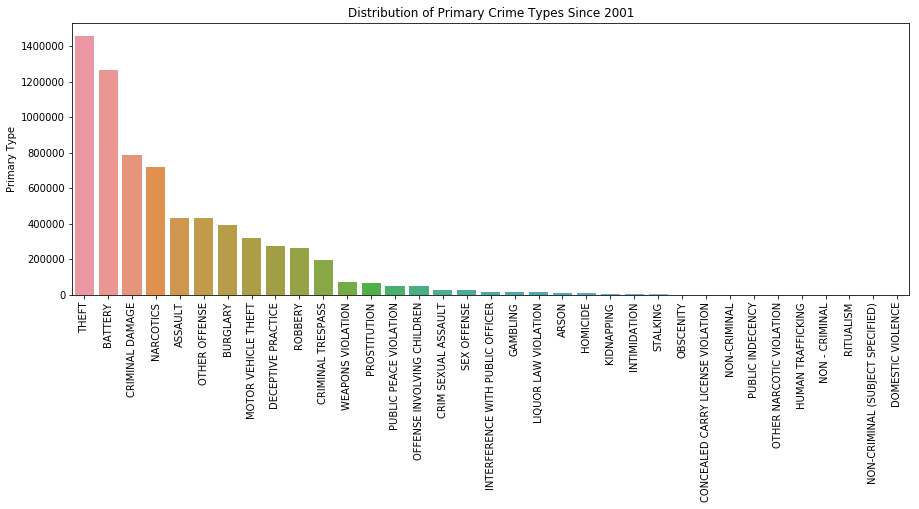

In [10]:
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Primary Type'].value_counts().index, y=df['Primary Type'].value_counts())
plt.xticks(rotation=90)
plt.title('Distribution of Primary Crime Types Since 2001')
plt.show()

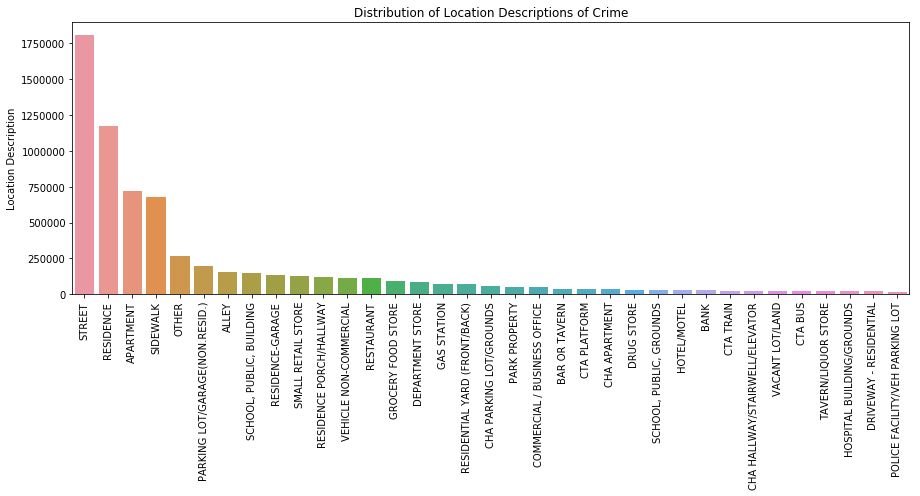

In [11]:
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Location Description'].value_counts().index[:35], y=df['Location Description'].value_counts()[:35])
plt.xticks(rotation=90)
plt.title('Distribution of Location Descriptions of Crime')
plt.show()

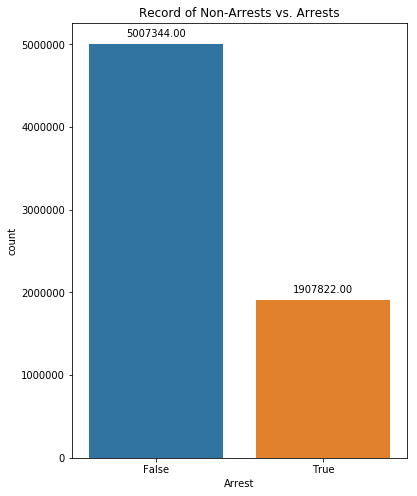

In [12]:
plt.figure(figsize=(6, 8))
g = sns.countplot(df['Arrest'])
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), 
               ha = 'center', 
               va = 'center', 
               xytext = (0, 10), 
               textcoords = 'offset points')

plt.title('Record of Non-Arrests vs. Arrests')
plt.show()

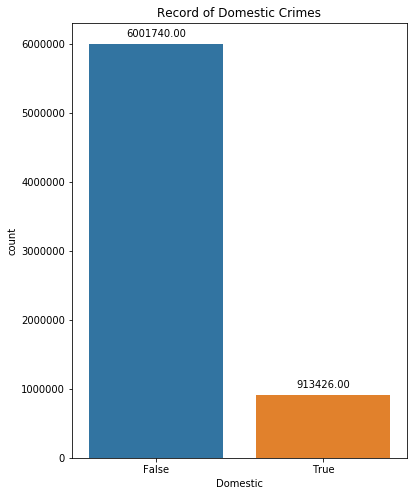

In [13]:
plt.figure(figsize=(6, 8))
g = sns.countplot(df['Domestic'])
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), 
               ha = 'center', 
               va = 'center', 
               xytext = (0, 10), 
               textcoords = 'offset points')

plt.title('Record of Domestic Crimes')
plt.show()

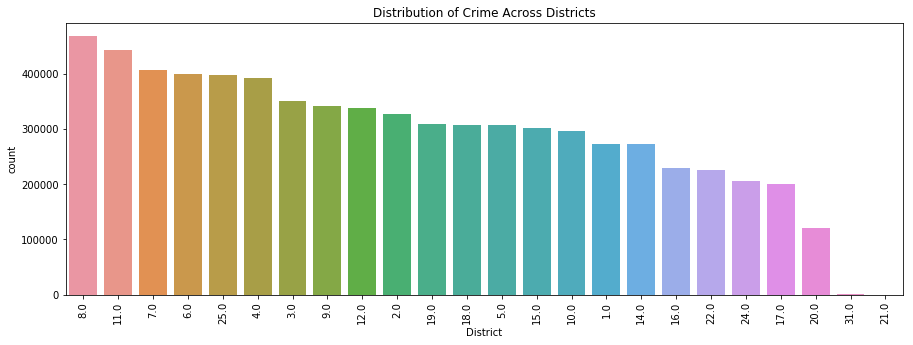

In [14]:
plt.figure(figsize=[15,5])
sns.countplot(x = 'District',
              data = df,
              order = df['District'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Crime Across Districts')
plt.show()

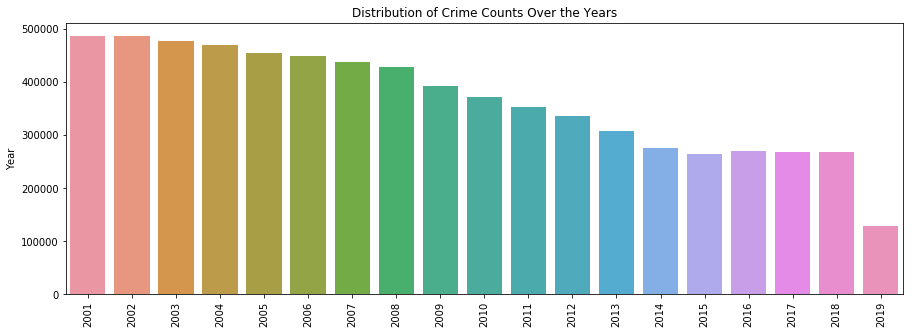

In [15]:
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Year'].value_counts().index, y=df['Year'].value_counts())
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Over the Years')
plt.show()

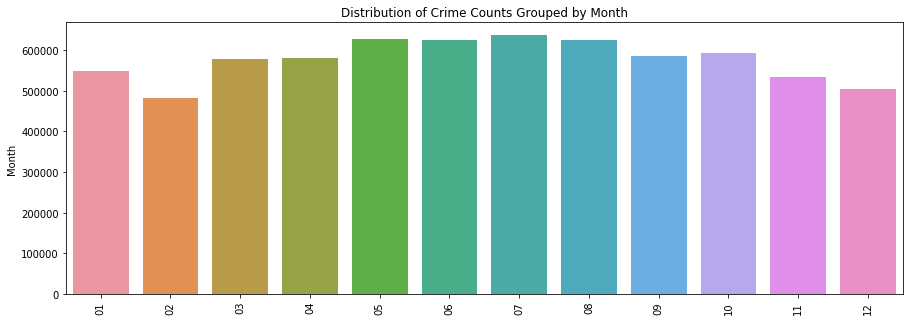

In [16]:
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Month'].value_counts().index, y=df['Month'].value_counts())
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Grouped by Month')
plt.show()

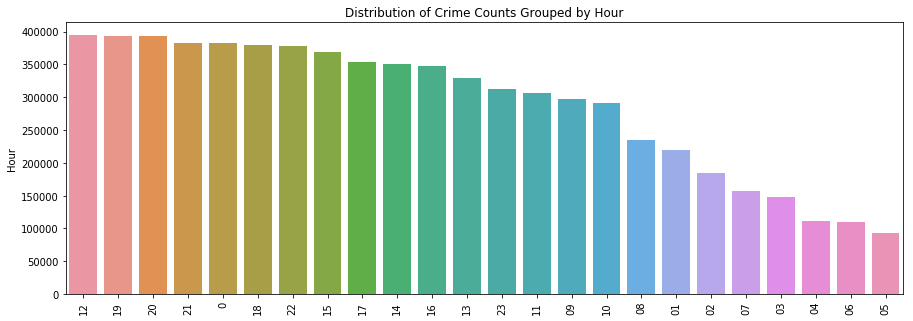

In [17]:
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Hour'].value_counts().index, y=df['Hour'].value_counts())
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Grouped by Hour')
plt.show()

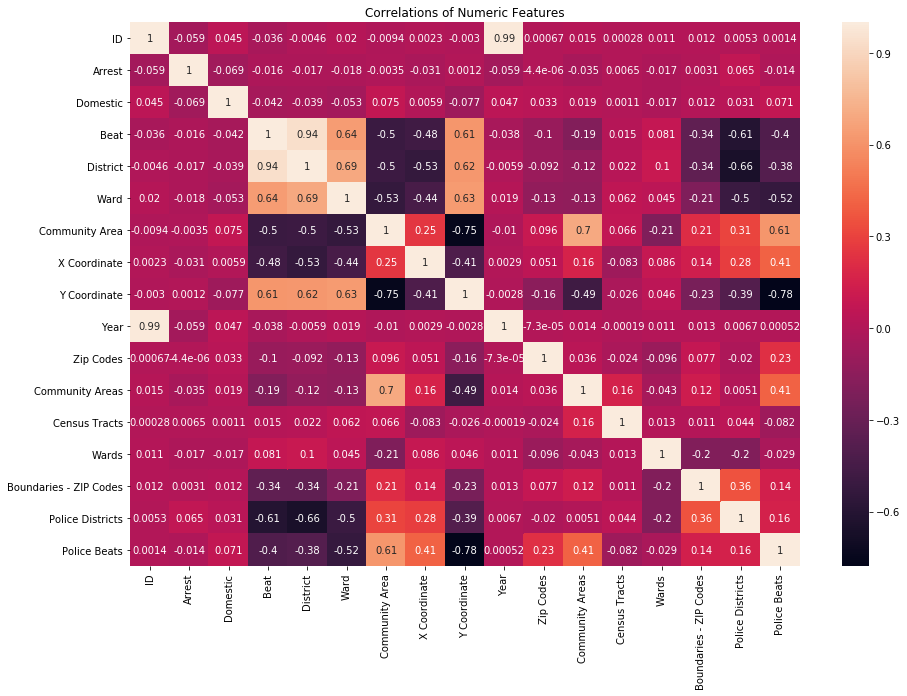

In [18]:
plt.figure(figsize=[15,10])
sns.heatmap(df.corr(), annot=True)
plt.title('Correlations of Numeric Features')
plt.show()

### B. Geographical Analysis

In [19]:
# Removing entries with missing geographical data
geographical_df = df[~df.Location.isna()]

In [20]:
# Empty lists for seperating location into latitude and longitude
latitude = [] # north/south position
longitude = [] # east/west position

# Populating lists with latitude and longitude for geo-plotting
for location in geographical_df.Location:
    latitude.append(float(location[location.find("(")+1:location.find(",")]))
    longitude.append(float(location[location.find(",")+2:location.find(")")]))

geographical_df['Latitude'] = latitude
geographical_df['Longitude'] = longitude

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [21]:
# Removing 168 noticeable erroneous instances where geographic location is set to Missouri
geographical_df = geographical_df.drop(geographical_df[geographical_df.Longitude == geographical_df.Longitude.min()].index)
geographical_df.shape

(6843562, 30)

In [22]:
# Creating GeoPanda specific feature with geo-data
geometry = [Point(xy) for xy in zip(geographical_df.Longitude, geographical_df.Latitude)]

# Specifying GeoPanda CRS (tells Python how those coordinates related to places on the Earth specifically)
crs = {'init':'epsg:4326'}

# Populating GeoPanda df
geo_df = gpd.GeoDataFrame(geographical_df, #specify data
                         crs = crs, # specify coordinate reference system
                         geometry = geometry) #specify created geometry list

In [23]:
chicago_map = gpd.read_file('Boundaries - Community Areas (current)/geo_export_c383d553-bf2b-43a7-b020-37bc28e65a5d.shp')

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


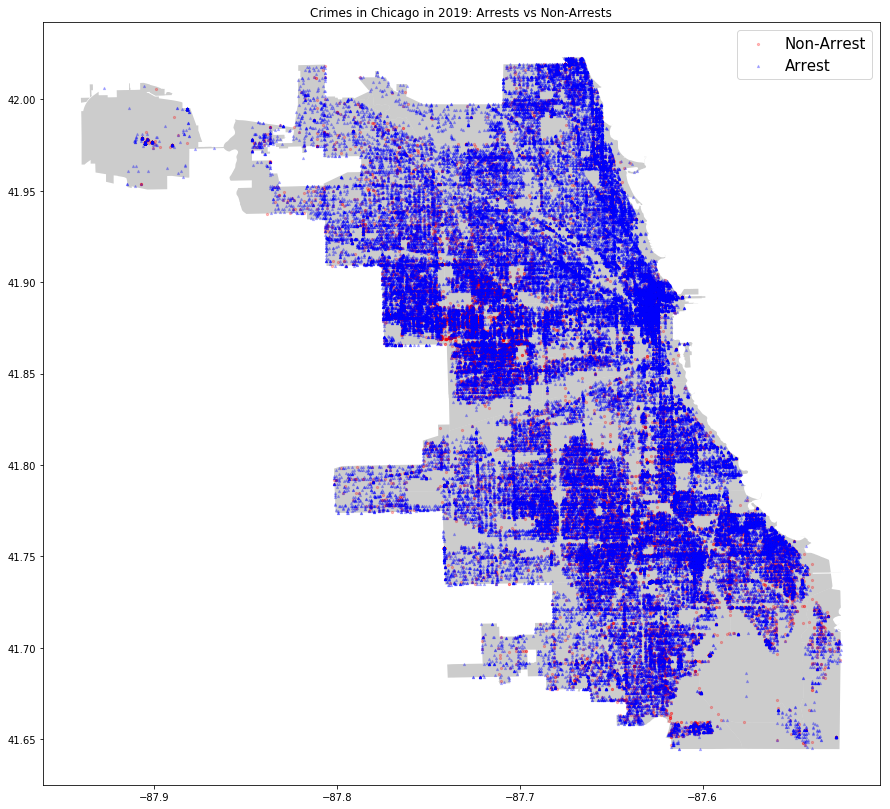

In [24]:
fig, ax = plt.subplots(figsize=(15,15))

# Plotting map
chicago_map.plot(ax=ax, alpha=0.4, color='grey')

# Plotting arrests and non-arrests on map
geo_df[geo_df['Arrest'] == True][geo_df['Year'] == 2019].plot(ax=ax, 
                                                              markersize=5, 
                                                              color='red', 
                                                              marker='o', 
                                                              alpha=.25, 
                                                              label='Non-Arrest')
geo_df[geo_df['Arrest'] == False][geo_df['Year'] == 2019].plot(ax=ax, 
                                                               markersize=5, 
                                                               color='blue', 
                                                               marker='^', 
                                                               alpha=.25, 
                                                               label='Arrest')
plt.legend(prop={'size':15})
plt.title('Crimes in Chicago in 2019: Arrests vs Non-Arrests')
plt.show()

### C. Weather Analysis
The following weather data was taken from the [ASOS Network](https://mesonet.agron.iastate.edu/request/download.phtml?network=IL_ASOS) from Iowa State University. This dataset begins in January of 2000 and continues to the present. The entries were collected from the *[ORD] Chicago O'Hare* station within the network *Illinois ASOS*.
#### i. Preparing Weather Data

In [171]:
# Removing unnecessary features
weather_df = pd.read_csv('Weather Data/ORD.txt').drop(['station','vsby','skyc1','skyc2','skyc3','skyc4',
                                                      'skyl1','skyl2','skyl3','skyl4','wxcodes',
                                                      'ice_accretion_1hr','ice_accretion_3hr','ice_accretion_6hr',
                                                      'peak_wind_gust','peak_wind_drct','peak_wind_time', 'metar'], 1)

# Renaming columns
weather_df.columns = (['timestamp','air_temp','dew_pt_temp','rel_humidity','wind_direction','wind_speed',
                       'precipitation_by_hour','alti_pressure','sea_level_pressure','wind_gust','real_feel_temp'])

In [172]:
# Creating new feature that only includes date
date_hour = []
for entry in weather_df.timestamp:
    date_hour.append(entry[:13])

# Adding timesplits to DataFrame
weather_df['date_hour'] = date_hour

In [173]:
# Condensing data to hourly records
weather_df = weather_df.groupby(['date_hour']).mean()

# Observing dataset traits
print(weather_df.shape)
weather_df.isna().sum()

(170880, 10)


air_temp                     66
dew_pt_temp                  71
rel_humidity                363
wind_direction             2548
wind_speed                  260
precipitation_by_hour    103767
alti_pressure                46
sea_level_pressure         1073
wind_gust                136772
real_feel_temp              447
dtype: int64

In [174]:
# Adding date feature
date = []
for entry in weather_df.index:
    date.append(entry[:10])
    
weather_df['date'] = date

In [175]:
# Filling missing hours of day with average daily record per feature
for col in weather_df.columns:
    if col == 'date':
        continue
    else:
        weather_df[str(col)] = weather_df.groupby("date")[str(col)].transform(lambda x: x.fillna(x.mean()))

In [176]:
# Filling remaining missing values: result of insignificant, non-measurable instances essentially equal to zero.
weather_df['precipitation_by_hour'].fillna(0, inplace= True)
weather_df['wind_gust'].fillna(0, inplace= True)

In [177]:
# Missing values are only from last three days (24 hours * 3 days = 72 entries)
weather_df.isnull().sum()

air_temp                  0
dew_pt_temp               0
rel_humidity              0
wind_direction            0
wind_speed                0
precipitation_by_hour     0
alti_pressure             0
sea_level_pressure        0
wind_gust                 0
real_feel_temp           72
date                      0
dtype: int64

#### ii. Merging Weather Data with Crime Data

In [178]:
# Creating mutual feature to merge weather with crime according to date and hour
temporary_merge = weather_df.index
weather_df['merging_date_hour'] = temporary_merge

# Creating mutual feature to merge crime with weather according to date and hour
temporary_merge = df.Year.astype(str)+'-'+df.Month.astype(str)+'-'+df.Day.astype(str)+' '+df.Hour.astype(str)

# Crime DataFrame is missing trailing zero: therefore, we will add a zero for the midnight hour
for lacking_zero in temporary_merge[temporary_merge.str[-2:] == ' 0'].index:
    temporary_merge[lacking_zero] = temporary_merge[lacking_zero] + '0'
df['merging_date_hour'] = temporary_merge

In [179]:
# Merging crime and weather DataFrames
df = df.merge(weather_df, how='left', left_on='merging_date_hour', right_on='merging_date_hour')    

# Some hours are missing. Filling Nan values with preceding hour information.
df[weather_df.columns] = df[weather_df.columns].fillna(method='ffill')

# Removing superfluous joining column
df.drop('merging_date_hour', axis=1, inplace=True)

In [180]:
df.isnull().sum()

ID                             0
Case Number                    4
Block                          0
IUCR                           0
Primary Type                   0
Description                    0
Location Description        5237
Arrest                         0
Domestic                       0
Beat                           0
District                      47
Ward                      614825
Community Area            613495
X Coordinate               71442
Y Coordinate               71442
Year                           0
Location                   71442
Zip Codes                  71442
Community Areas            88611
Census Tracts              86458
Wards                      88499
Boundaries - ZIP Codes     88564
Police Districts           87534
Police Beats               87511
Month                          0
Day                            0
Hour                           0
Minute                         0
weekday                        0
air_temp                       0
dew_pt_tem

#### iii. Analyzing Interplay Between Crime and Weather

In [181]:
#Creating temperature bins in crime DataFrame to easily categorize continuous variable of temperature
increments_of_five = np.linspace(-55, 115, 35)
df['real_feel_buckets'] = pd.cut(df['real_feel_temp'], increments_of_five)

In [182]:
# Creating temperature bins in weather DataFrame to count number of occurences in history
weather_df['real_feel_buckets'] = pd.cut(weather_df['real_feel_temp'], increments_of_five)
weather_df.head()

,air_temp,dew_pt_temp,rel_humidity,wind_direction,wind_speed,precipitation_by_hour,alti_pressure,sea_level_pressure,wind_gust,real_feel_temp,date,merging_date_hour,real_feel_buckets
date_hour,,,,,,,,,,,,,
2000-01-01 08,37.40,30.20,74.98,210.000000,8.0,0.0,30.00,1013.333333,0.0,30.77,2000-01-01,2000-01-01 08,"(30.0, 35.0]"
2000-01-01 09,39.92,30.92,69.96,210.000000,4.0,0.0,30.01,1016.900000,0.0,36.67,2000-01-01,2000-01-01 09,"(35.0, 40.0]"
2000-01-01 10,44.06,30.92,59.64,153.333333,6.0,0.0,30.01,1016.500000,0.0,40.05,2000-01-01,2000-01-01 10,"(40.0, 45.0]"
2000-01-01 11,44.96,30.92,57.63,210.000000,6.0,0.0,29.97,1015.400000,0.0,41.14,2000-01-01,2000-01-01 11,"(40.0, 45.0]"
2000-01-01 12,46.04,30.02,53.33,230.000000,5.0,0.0,29.95,1014.800000,0.0,43.07,2000-01-01,2000-01-01 12,"(40.0, 45.0]"


In [183]:
# Removing weather data that precedes available crime data
weather_df = weather_df.drop(weather_df[weather_df.date < min(df.date)].index)

# Counting occurences of crime per weather bucket and occurences of temperature occurence per weather bucket
crimes_per_weather_bucket = df.groupby(['real_feel_buckets'])['ID'].count()
temp_occurences_per_weather_bucket = weather_df.groupby(['real_feel_buckets'])['merging_date_hour'].count()

In [184]:
# Quantifying probability of crime per hour given a certain temperature within weather bucket
crimes_per_occurence = crimes_per_weather_bucket / temp_occurences_per_weather_bucket

In [185]:
# Creating DataFrame for easy manipulation
crime_weather_df = pd.DataFrame(crimes_per_occurence, columns=['crimes_per_occurence'])
crime_weather_df.reset_index(level=0, inplace=True)
crime_weather_df.real_feel_buckets = crime_weather_df.real_feel_buckets.astype(str)

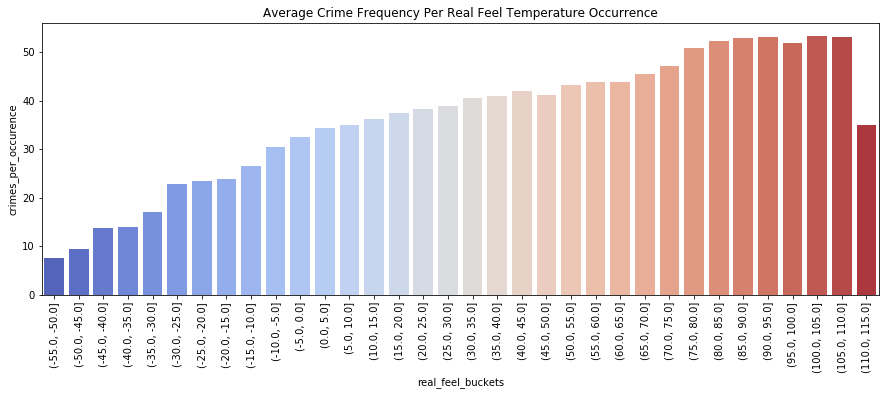

,real_feel_buckets,crimes_per_occurence
24,"(65.0, 70.0]",45.461598
25,"(70.0, 75.0]",47.081266
26,"(75.0, 80.0]",50.804277
27,"(80.0, 85.0]",52.345311
28,"(85.0, 90.0]",52.791779
29,"(90.0, 95.0]",53.007864
30,"(95.0, 100.0]",51.935484
31,"(100.0, 105.0]",53.299492
32,"(105.0, 110.0]",53.036364
33,"(110.0, 115.0]",35.000000


In [144]:
# Plotting Crime Frequency per Real Feel Temperature occurrence
plt.figure(figsize=[15,5])
sns.barplot(x='real_feel_buckets', y='crimes_per_occurence', data=crime_weather_df, palette="coolwarm")
plt.xticks(rotation=90)
plt.title('Average Crime Frequency Per Real Feel Temperature Occurrence')
plt.show()

crime_weather_df.tail(10)

To briefly explain the chart above, the crimes were binned according to their real feel temperature at the time of the crime and the temperature occurrences were binned according to their real feel temperature frequency. To provide an example, cold hours like the far left were infrequent (as can be seen in `crimes_per_weather_bucket` - there are only 15 hour recordings since 2001) and the crimes recorded during an hour where the temperature fell within this bin was correlatingly infrequent (with only 2 crimes reporting - as can be seen in `temp_occurences_per_weather_bucket`) meaning that, on average, in a given hour where the temperature fell between -50 and -55 degrees only 7.5 crimes were committed. 

This explained, it is jarringly apparent that there is a causal relationship of temperature on crime frequency.

## Section 4: Feature Engineering

In [193]:
# Using IUCR codes to create categorical target variables of crime
IUCR_homicides = ['0110','0130','0141','0142']
IUCR_sex_assaults = ['0261','0262','0263','0264','0265','0266','0271','0272','0273','0274','0275','0281','0291']
IUCR_battery = ['041A','041B','0420','0430','0440','0450','0451','0452','0453','0454','0460','0461','0462','0475','0479',
                '0480','0481','0482','0483','0484','0485','0486','0487','0488','0489','0495','0496','0497','0498']
IUCR_assault = ['051A','051B','0520','0530','0545','0550','0551','0552','0553','0554','0555','0556','0557','0558','0560']

In [206]:
print('Percentage of HOMICIDE to total recorded crimes:\n', 
      (df.IUCR.isin(IUCR_homicides).sum() / len(df.IUCR))*100, '\n',
     df.IUCR.isin(IUCR_homicides).sum())
print('Percentage of SEXUAL ASSAULT to total recorded crimes:\n', 
      (df.IUCR.isin(IUCR_sex_assaults).sum() / len(df.IUCR))*100, '\n',
     df.IUCR.isin(IUCR_sex_assaults).sum())
print('Percentage of BATTERY to total recorded crimes:\n', 
      (df.IUCR.isin(IUCR_battery).sum() / len(df.IUCR))*100, '\n',
     df.IUCR.isin(IUCR_battery).sum())
print('Percentage of ASSAULT to total recorded crimes:\n', 
      (df.IUCR.isin(IUCR_assault).sum() / len(df.IUCR))*100, '\n',
     df.IUCR.isin(IUCR_assault).sum())

Percentage of HOMICIDE to total recorded crimes:
 0.14128366549696708 
 9770
Percentage of SEXUAL ASSAULT to total recorded crimes:
 0.40940448862688184 
 28311
Percentage of BATTERY to total recorded crimes:
 18.255353522966765 
 1262388
Percentage of ASSAULT to total recorded crimes:
 6.244101732337301 
 431790


In [155]:
np.where(df['Primary Type'] == 'HOMICIDE', 1, 0).sum()

9770

In [157]:
np.where(df['Primary Type'] == 'PROSTITUTION', 1, 0).sum()

68725

In [158]:
np.where(df['Primary Type'] == 'ASSAULT', 1, 0).sum()

431790

In [159]:
np.where(df['Primary Type'] == 'RITUALISM', 1, 0).sum()

23